https://github.com/huggingface/peft/blob/main/examples/image_classification/image_classification_peft_lora.ipynb

In [ ]:
# Code block to import own data in cloud
from google.colab import drive
drive.mount('/content/drive')
!rm -rf /content/hku_selfsup
!git clone -b main https://github.com/Colinnnnnm/hku_selfsup.git
!cp -r /content/drive/MyDrive/pretrained_model /content/pretrained_model
!cp -r /content/drive/MyDrive/data /content/hku_selfsup/data
!unzip -q /content/hku_selfsup/data/Market-1501-v15.09.15.zip -d /content/hku_selfsup/data
!mv /content/hku_selfsup/data/Market-1501-v15.09.15 /content/hku_selfsup/data/market1501
!unzip -q /content/hku_selfsup/data/market1501_grey.zip -d /content/hku_selfsup/data
!unzip -q /content/hku_selfsup/data/cuhk03.zip -d /content/hku_selfsup/data
!unzip -q /content/hku_selfsup/data/cuhk03_grey.zip -d /content/hku_selfsup/data
!cp /content/hku_selfsup/data/cuhk03/cuhk03_new_protocol_config_detected.mat /content/hku_selfsup/data/cuhk03_grey
!cp /content/hku_selfsup/data/cuhk03/cuhk03_new_protocol_config_labeled.mat /content/hku_selfsup/data/cuhk03_grey
!unzip -q /content/hku_selfsup/data/DukeMTMC-reID.zip -d /content/hku_selfsup/data
!mv /content/hku_selfsup/data/DukeMTMC-reID /content/hku_selfsup/data/duke
!unzip -q /content/hku_selfsup/data/duke_grey.zip -d /content/hku_selfsup/data
import torch
import numpy as np
import glob
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import argparse
import os
os.chdir("/content/hku_selfsup/TransReID-SSL/transreid_pytorch")
# Then interact with your own folder of data

Mounted at /content/drive
Cloning into 'hku_selfsup'...
remote: Enumerating objects: 3689, done.
remote: Counting objects: 100% (2418/2418), done.
remote: Compressing objects: 100% (1632/1632), done.
remote: Total 3689 (delta 921), reused 2207 (delta 741), pack-reused 1271
Receiving objects: 100% (3689/3689), 63.37 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (1271/1271), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np

In [ ]:
!pip install transformers accelerate evaluate datasets git+https://github.com/huggingface/peft -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.

In [ ]:
import transformers
import accelerate
import peft

In [ ]:
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.34.0
Accelerate version: 0.23.0
PEFT version: 0.6.0.dev0


In [ ]:
ls /content/pretrained_model

dino_deitsmall16_pretrain.pth  dino_vitbase16_pretrain.pth     vit_base_ics_cfs_lup.pth
dino_deitsmall8_pretrain.pth   dino_vitbase8_pretrain.pth      vit_small_cfs_lup.pth
dinov2_vitb14_pretrain.pth     extracted_sam_vit_b_01ec64.pth  vit_small_cfs_lup_updated.pth
dinov2_vits14_pretrain.pth     extracted_sam_vit_h_4b8939.pth  vit_small_ics_cfs_lup.pth


In [ ]:
# config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
pretrained_model_path = "/content/drive/My Drive/pretrained_model/dinov2_vitb14_pretrain.pth"

In [ ]:
model_checkpoint = pretrained_model_path  # pre-trained model from which to fine-tune

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dino_model.load_state_dict(torch.load(pretrained_model_path))
dino_model = dino_model.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 229MB/s]


In [ ]:
path = '/content/drive/MyDrive/data/Market-1501-v15.09.15.zip'

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
'''model = dino_model.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
print_trainable_parameters(model)
'''

"model = dino_model.from_pretrained(\n    model_checkpoint,\n    label2id=label2id,\n    id2label=id2label,\n    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint\n)\nprint_trainable_parameters(model)\n"

In [ ]:
model = dino_model

In [ ]:
print(model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 589824 || all params: 87170304 || trainable%: 0.68


In [ ]:
ls /content/hku_selfsup/data/market1501/

bounding_box_test/  bounding_box_train/  gt_bbox/  gt_query/  query/  readme.txt


In [ ]:
dataset =

SyntaxError: ignored

In [ ]:

labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

NameError: ignored

In [ ]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=False,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
ls /content/hku_selfsup/data/market1501/

bounding_box_test/  bounding_box_train/  gt_bbox/  gt_query/  query/  readme.txt


In [ ]:
ls /content/hku_selfsup/data

cfs_list.pkl  cuhk03_grey.zip     duke/          DukeMTMC-reID.zip  market1501_grey/
cuhk03/       cuhk03_release.zip  duke_grey/     __MACOSX/          market1501_grey.zip
cuhk03_grey/  cuhk03.zip          duke_grey.zip  market1501/        Market-1501-v15.09.15.zip


In [ ]:
ls /content/hku_selfsup/data/market1501/gt_bbox

Streaming output truncated to the last 5000 lines.
0194_c1s1_038051_00.jpg  0654_c6s2_030293_00.jpg  1158_c2s2_160727_00.jpg
0194_c1s1_060031_00.jpg  0654_c6s2_030318_00.jpg  1158_c2s2_160752_00.jpg
0194_c1s1_060056_00.jpg  0655_c1s3_051276_00.jpg  1158_c2s2_160852_00.jpg
0194_c1s1_060131_00.jpg  0655_c1s4_003181_00.jpg  1158_c2s3_037707_00.jpg
0194_c1s1_060181_00.jpg  0655_c1s4_003206_00.jpg  1158_c2s3_037782_00.jpg
0194_c2s1_037501_00.jpg  0655_c3s2_036887_00.jpg  1158_c2s3_037807_00.jpg
0194_c2s1_037551_00.jpg  0655_c3s2_036912_00.jpg  1158_c3s3_001712_00.jpg
0194_c2s1_059721_00.jpg  0655_c3s2_036987_00.jpg  1158_c3s3_001762_00.jpg
0194_c2s1_059746_00.jpg  0655_c3s2_063503_00.jpg  1158_c3s3_001837_00.jpg
0194_c2s2_144802_00.jpg  0655_c3s2_063528_00.jpg  1158_c3s3_044103_00.jpg
0194_c3s1_037701_00.jpg  0655_c3s2_063553_00.jpg  1158_c3s3_044153_00.jpg
0194_c3s1_037751_00.jpg  0655_c3s2_063753_00.jpg  1158_c3s3_044228_00.jpg
0194_c3s1_059342_00.jpg  0655_c5s2_037230_00.jpg  1158_c3s3_0

In [ ]:
ls /content/hku_selfsup/data/duke/

bounding_box_test/   CITATION.txt               LICENSE_DukeMTMC.txt  README.md
bounding_box_train/  LICENSE_DukeMTMC-reID.txt  query/


In [ ]:
ls /content/hku_selfsup/data/cuhk03/

cuhk03_new_protocol_config_detected.mat  images_detected/              splits_classic_labeled.json
cuhk03_new_protocol_config_labeled.mat   images_labeled/               splits_new_detected.json
cuhk03_release/                          splits_classic_detected.json  splits_new_labeled.json


In [ ]:
ls /content/hku_selfsup/data/market1501/bounding_box_test/0378_c5s1_123945_02.jpg

/content/hku_selfsup/data/market1501/bounding_box_test/0378_c5s1_123945_02.jpg


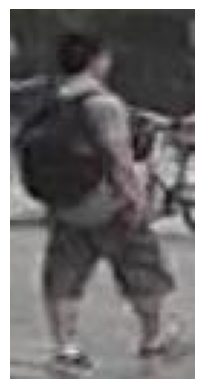

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Specify the path to your JPEG file
image_path = '/content/hku_selfsup/data/market1501/gt_bbox/0450_c5s1_122170_00.jpg'

# Open the image file
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
ls /content

drive/  hku_selfsup/  pretrained_model/  sample_data/


In [ ]:
ls /content/pretrained_model

dino_deitsmall16_pretrain.pth  dino_vitbase16_pretrain.pth     vit_base_ics_cfs_lup.pth
dino_deitsmall8_pretrain.pth   dino_vitbase8_pretrain.pth      vit_small_cfs_lup.pth
dinov2_vitb14_pretrain.pth     extracted_sam_vit_b_01ec64.pth  vit_small_cfs_lup_updated.pth
dinov2_vits14_pretrain.pth     extracted_sam_vit_h_4b8939.pth  vit_small_ics_cfs_lup.pth


In [ ]:
ls /content/hku_selfsup/

contrasive/        DinoAttention.ipynb         PASS-reID/                           TransReID/
data/              dinov2/                     README.md                            TransReID-SSL/
dataset/           environment-linux.yml       segment-anything/
deep-person-reid/  environment.yml             SimpleDinoLabellingExperiment.ipynb
dino/              Occluded-DukeMTMC-Dataset/  Transfer-Learning-Library/
